In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
maxdate = session.query(func.max(Measurement.date)).all()[0][0]
max_datetime = dt.datetime.strptime(maxdate, '%Y-%m-%d')
year_ago = max_datetime - dt.timedelta(days=365)
max_datetime = max_datetime.strftime("%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
year_ago = year_ago.strftime("%Y-%m-%d")
print(max_datetime)
print(year_ago)

# session.query(Measurement.date).order_by(Measurement.date.desc()).first()

2017-08-23
2016-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation score
titles_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
titles_db = pd.DataFrame(titles_query).sort_values(by="date")
titles_db = titles_db.dropna()
titles_db2 = titles_db.set_index('date')

In [14]:
titles_db2

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


([], <a list of 0 Text xticklabel objects>)

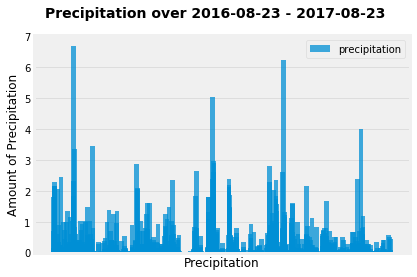

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()

fig.suptitle(f"Precipitation over {year_ago} - {max_datetime}", fontsize=14, fontweight="bold")
ax.set_xlabel("Precipitation")
ax.set_ylabel("Amount of Precipitation")

ax.grid(alpha=0.5)

bargraph = ax.bar(titles_db2.index, titles_db2["prcp"],align="center", width=5, alpha=0.75)
bargraph.set_label("precipitation")
ax.legend()

# plt.figure(figsize=(200,500))
plt.xticks([])

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
titles_db2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
stations_query = session.query(Station).count()
stations_query

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations_query = session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(desc('count'))
activestations_db = pd.DataFrame(activestations_query, columns=['Station','Count'])
activestations_db

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
maxstation = activestations_db.max()["Station"]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

activestation_tobs = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==maxstation).all()
print(f"Min: {activestation_tobs[0][0]}, Max: {activestation_tobs[0][1]}, Avg: {round(activestation_tobs[0][2],2)}")

Min: 56.0, Max: 85.0, Avg: 74.54


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_query = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station==maxstation).all()
activestations_db = pd.DataFrame(tobs_query, columns=['TOBS'])
activestations_db


,TOBS
0,80.0
1,79.0
2,80.0
3,84.0
4,81.0
5,80.0
6,79.0
7,78.0
8,78.0
9,81.0


Text(0.5, 0, 'Temperature')

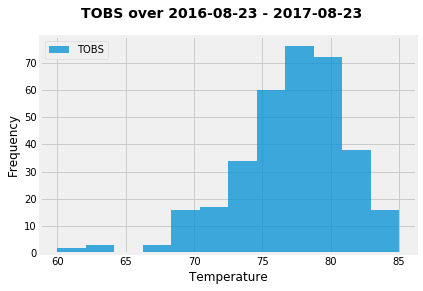

In [22]:
histogram = plt.hist(activestations_db['TOBS'],bins=12, label='TOBS', alpha=0.75)
plt.suptitle(f"TOBS over {year_ago} - {max_datetime}", fontsize=14, fontweight="bold")
plt.legend(loc='upper left')
plt.ylabel("Frequency")
plt.xlabel("Temperature")

## Optional Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-01','2016-08-06'))

[(72.0, 77.63157894736842, 82.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min, avg, max = calc_temps('2016-08-01','2016-08-06')[0]

Text(0, 0.5, 'Temp (F)')

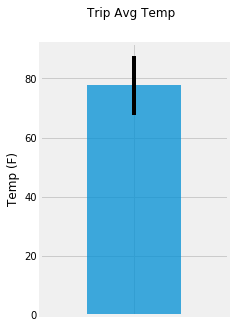

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = max - min

fig, ax = plt.subplots(figsize=(3,5))
ax.bar([''],avg, yerr = error, align="center", width=2, alpha=0.75)
ax.set_xlim(-2,2)

fig.suptitle("Trip Avg Temp")
ax.set_ylabel("Temp (F)")


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_query = session.query(Measurement.station, func.sum(Measurement.prcp).label('sum')).group_by(Measurement.station).filter(Measurement.date >= '2016-08-01').filter(Measurement.date <= '2016-08-06').order_by(desc('sum'))
rainfall_db = pd.DataFrame(rainfall_query, columns=['Station','Sum'])
rainfall_db


,Station,Sum
0,USC00519281,5.55
1,USC00516128,3.35
2,USC00513117,3.29
3,USC00519523,0.90
4,USC00514830,0.55
5,USC00519397,0.18
6,USC00517948,0.18


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
start = dt.datetime.strptime("08-01", "%m-%d")
end = dt.datetime.strptime("08-06", "%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days + 1)]

# Stip off the year and save a list of %m-%d strings
vacation_days = []
for date in date_generated:
    vacation_days.append(date.strftime("%m-%d"))
print(vacation_days)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for days in vacation_days:
    normals.append(daily_normals(days)[0])
print(normals)

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06']
[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0)]


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacation_df = pd.DataFrame(normals, columns=['min','avg','max'])
vacation_df["dates"] = vacation_days
vacation_df = vacation_df.set_index("dates")
vacation_df

,min,avg,max
dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0


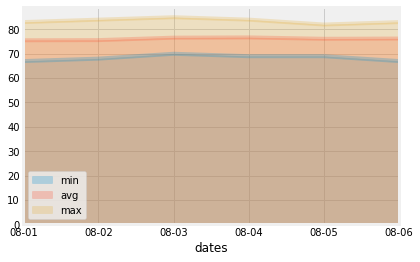

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
ax = vacation_df.plot.area(alpha=0.25, stacked=False)

In [42]:
june_query = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
december_query = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()

june_tobs = [x for x in june_query]
december_tobs = [x for x in december_query]

june_mean = np.mean(june_tobs)
december_mean = np.mean(december_tobs)

In [51]:
stats.ttest_ind(june_tobs, december_tobs, equal_var=False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))